In [2]:
suppressPackageStartupMessages({
    source('/data/srlab/ik936/Fiona/R/libs.R')
    source('/data/srlab/ik936/Fiona/R/utils.R')
})


# Load gut data

In [4]:
modules <- fread('data/WGCNA_all.csv')[, N := .N, by = moduleColor][N < 2000]

In [3]:
exprs_raw <- readRDS('/data/srlab/ik936/Roche/data/cache/exprs_raw_matrix_n79_Mar30_2020.rds')
meta_data <- readRDS('/data/srlab/ik936/Roche/data/cache/cell_df_Mar30_2020.rds') %>% 
    subset(nGene > 500 & percent_mito < .2 & Tissue == 'Gut')
exprs_raw <- exprs_raw[, meta_data$CellID]


In [4]:
dim(exprs_raw)
dim(meta_data)

[1] 19952 31224

[1] 31224    11

In [5]:
readRDS('/data/srlab/ik936/Roche/data/cache/cell_df_Mar30_2020.rds') %>% 
    subset(nGene > 500 & percent_mito < .2 & Tissue == 'Gut') %>% 
    dplyr::select(LibraryID, Case, DonorID) %>% unique() %>% 
    subset(!LibraryID %in% meta_data$LibraryID) %>% 
    identity()


LibraryID,Case,DonorID
<chr>,<chr>,<chr>


## Add M&M's metadata

In [6]:
new_class_df <- tibble(
    LibraryID = c(
        paste0('BRI', c('137', '138', '013', '015', '021')),
        paste0('BRI', c('134', '114', '140')),
#         paste0('BRI', c('112', '136', '019', '152'))
        paste0('BRI', c('112', '136', '019'))
    ),
    Class = rep(c('low', 'int', 'high'), c(5, 3, 3))
)
new_class_df %>% arrange(LibraryID)


LibraryID,Class
<chr>,<chr>
BRI013,low
BRI015,low
BRI019,high
BRI021,low
BRI112,high
BRI114,int
BRI134,int
BRI136,high
BRI137,low


In [7]:
meta_data <- meta_data %>% 
    left_join(new_class_df) 


Joining, by = "LibraryID"



In [8]:
rownames(meta_data) <- meta_data$CellID

Warning message:
“Setting row names on a tibble is deprecated.”


In [9]:
meta_data <- subset(meta_data, !is.na(meta_data$Class))
exprs_raw <- exprs_raw[, meta_data$CellID]


In [10]:
dim(exprs_raw)
dim(meta_data)

[1] 19952 23394

[1] 23394    12

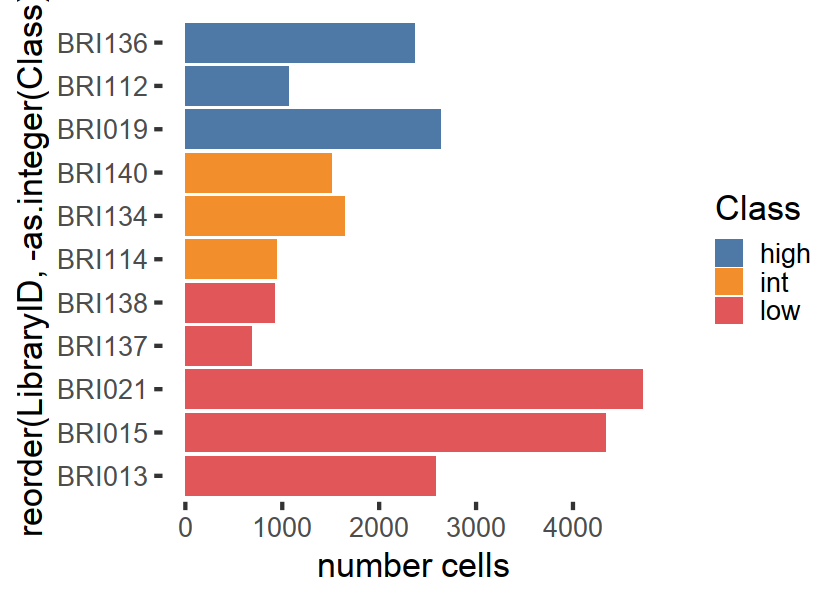

In [11]:
fig.size(5, 7)
meta_data %>% 
    group_by(Class, Case, LibraryID, DonorID) %>% summarize(n = n()) %>% ungroup() %>% 
    mutate(Class = factor(Class)) %>% 
    ggplot(aes(reorder(LibraryID, -as.integer(Class)), n, fill = Class)) + 
#     ggplot(aes(reorder(LibraryID, n), n, fill = Class)) + 
        geom_bar(stat = 'identity') + 
        theme_tufte(base_size = 20) + 
        scale_fill_tableau() + 
        labs(y = 'number cells') +
        coord_flip()


## Check SampleIDs

In [12]:
meta_mm <- '1	BRI-021	GI2065
2	BRI-015	GI2542
3	BRI-153	GI3380
4	BRI-138	GI3385
5	BRI-137	GI3389
6	BRI-019	IBD 1066
7	BRI-013	IBD 2763
8	BRI-152	IBD184 (1284)
9	BRI-140	IBD1272 inf
10	BRI-139	IBD1272 ni 
11	BRI-134	IBD1808 inf 
12	XX	IBD1808 ni
13	BRI-136	IBD3268 inf
14	BRI-135	IBD3268 ni
15	BRI-114	IBD2825 inf
16	MISSING	IBD2825 ni
17	BRI-112	IBD2809 inf
18	BRI-111	IBD 2809 ni' %>% fread() %>% 
    dplyr::select(LibraryID = V2, SampleID2 = V3) %>% 
    dplyr::mutate(LibraryID = gsub('-|_', '', LibraryID)) %>% 
    subset(grepl('^BRI', LibraryID))


All the sampleIDs agree except for `1281` and `1272`

In [13]:
readRDS('/data/srlab/ik936/Roche/data/cache/cell_df_Mar30_2020.rds') %>% 
    subset(nGene > 500 & percent_mito < .2 & Tissue == 'Gut') %>% 
    dplyr::select(LibraryID, SampleID, Case) %>% unique() %>% 
    arrange(Case, LibraryID) %>% 
    dplyr::left_join(meta_mm)


Joining, by = "LibraryID"



LibraryID,SampleID,Case,SampleID2
<chr>,<chr>,<chr>,<chr>
BRI015,GI2542,GutControl,GI2542
BRI021,GI2065,GutControl,GI2065
BRI137,GI3389,GutControl,GI3389
BRI138,GI3385,GutControl,GI3385
BRI153,GI3380,GutControl,GI3380
BRI013,IBD2763,GutInflamed,IBD 2763
BRI019,IBD1066,GutInflamed,IBD 1066
BRI112,IBD_2809_I,GutInflamed,IBD2809 inf
BRI114,IBD_2825_I,GutInflamed,IBD2825 inf


## Make object

In [14]:
do_harmony <- function (obj, vars, umap_min_dist = 0.1, ...) {
    hres <- HarmonyMatrix(obj$V, obj$meta_data, vars, do_pca = FALSE, 
        return_object = TRUE, ...)
    obj$Z_cos <- hres$Z_cos
    obj$Z_corr <- hres$Z_corr
    obj$R <- hres$R
    obj$umap_after <- uwot::umap(X = t(obj$Z_corr), n_threads = 6, 
        n_neighbors = 30L, n_components = 2L, metric = "cosine", 
        n_epochs = NULL, learning_rate = 1, min_dist = 0.3, spread = 1, 
        set_op_mix_ratio = 1, local_connectivity = 1L, repulsion_strength = 1, 
        negative_sample_rate = 1, a = NULL, b = NULL, fast_sgd = FALSE, 
        verbose = TRUE)
    return(obj)
}

In [18]:
set.seed(1)
obj <- create_object(exprs_raw, meta_data) %>% 
    do_harmony('LibraryID', theta=.5, max.iter.harmony=10, max.iter.cluster=20) %>% 
    do_cluster(c(.01, .05, .1))


start filter

Warning message in create_object(exprs_raw, meta_data):
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

15:38:58 UMAP embedding parameters a = 0.9922 b = 1.112

15:38:58 Read 23394 rows and found 20 numeric columns

15:38:58 Using Annoy for neighbor search, n_neighbors = 30

15:38:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:39:02 Writing NN index file to temp file /tmp/RtmpiPZLR4/file24e711eb7c1d

15:39:02 Searching Annoy index using 6 threads, search_k = 3000

15:39:04 Annoy recall = 100%

15:39:04 Commencing smooth kNN distance calibration using 6 

In [19]:
# obj <- do_cluster(obj, c(.05, .1, .2, .4), append_cols = FALSE)

Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


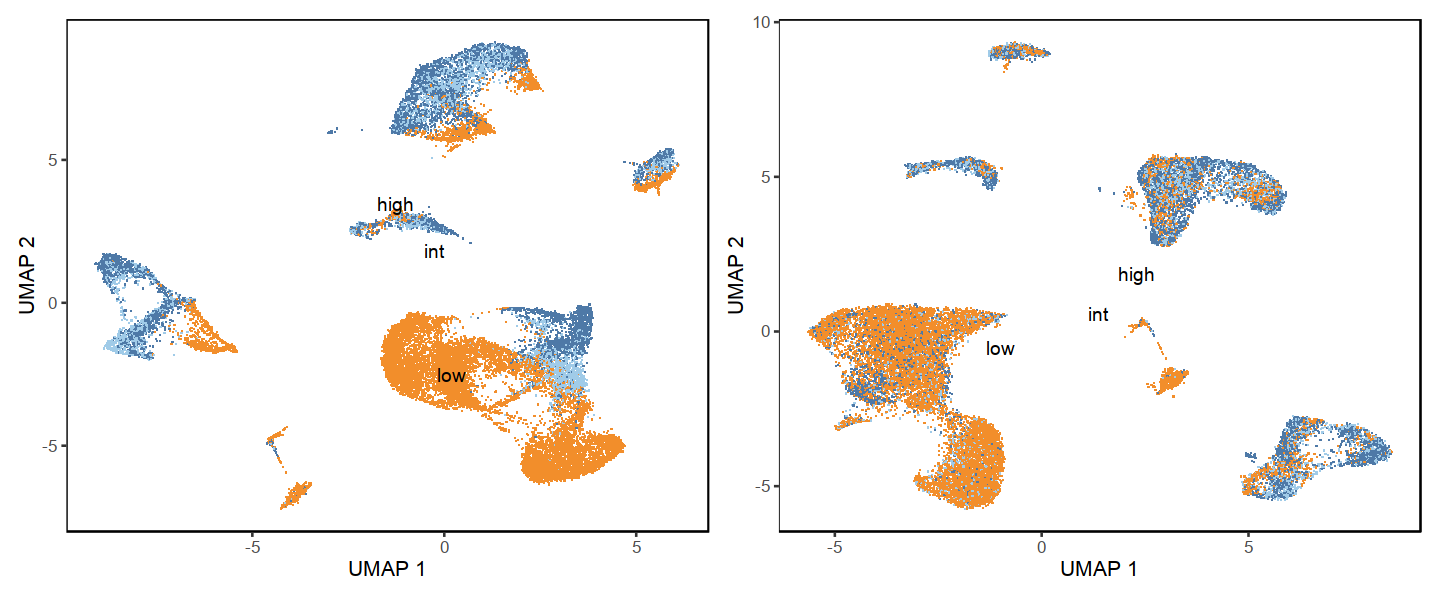

In [20]:
fig.size(5, 12)
do_scatter(obj$umap_before, obj$meta_data, 'Class') + 
do_scatter(obj$umap_after, obj$meta_data, 'Class')


# Lineage

In [21]:
apply(obj$clusters_df, 2, table)

$res1

    0     1     2     3     4     5 
12763  4618  3067  1196  1046   704 

$res2

   0    1    2    3    4    5    6 
8625 4618 4138 3067 1196 1046  704 

$res3

   0    1    2    3    4    5    6 
8625 4618 4138 3067 1196 1046  704 


Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


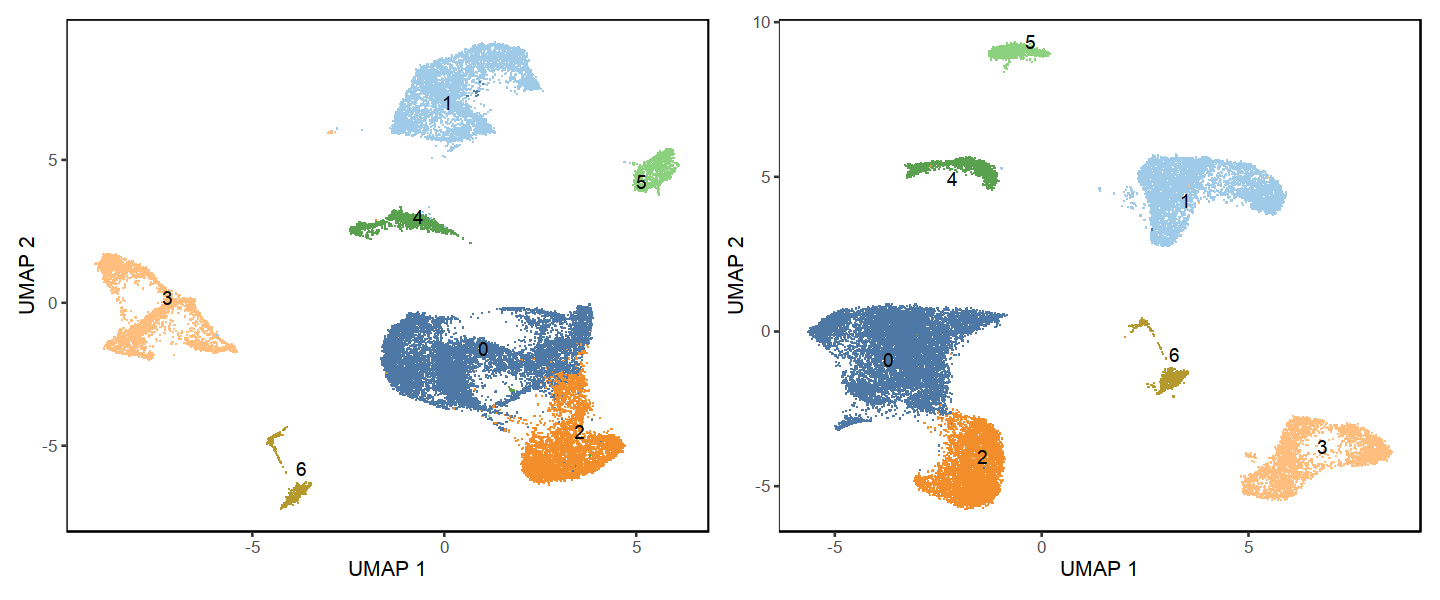

In [22]:
fig.size(5, 12)
do_scatter(obj$umap_before, obj$clusters_df, 'res3') + 
do_scatter(obj$umap_after, obj$clusters_df, 'res3')


In [23]:
top_markers(obj$markers$res3, 10)

rank,0,1,2,3,4,5,6
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,DCN,PLVAP,POSTN,KRT8,RGS5,CRYAB,CYBA
2,LUM,RAMP2,F3,KRT18,MYL9,S100B,RGS1
3,ADAMDEC1,PECAM1,CXCL14,ELF3,NDUFA4L2,CLU,SRGN
4,APOE,EGFL7,PDGFRA,PIGR,NOTCH3,PLP1,MZB1
5,CFD,RAMP3,PLAT,PHGR1,ACTA2,GPM6B,JCHAIN
6,FBLN1,GNG11,FRZB,CLDN4,CALD1,CD9,SSR4
7,C1S,RNASE1,COL6A2,CLDN3,IGFBP7,PMP22,HERPUD1
8,CTSC,VWF,BMP4,LGALS4,TPM1,LGI4,PIM2
9,COL1A2,ECSCR,VSTM2A,AGR2,EBF1,CNN3,FKBP11


In [24]:
obj <- name_clusters(
    obj, 
    'res3',
    'Lineage',
    list(
        'epithelial' = as.character(c(3)),
        'endothelial' = as.character(c(1)),
        'glial' = as.character(c(5)),
        'mesenchymal' = as.character(c(0, 2, 4)),
        'hematopoietic' = as.character(c(6))
    )
)

Warning message:
“Column `cluster_ids` joining factor and character vector, coercing into character vector”


Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


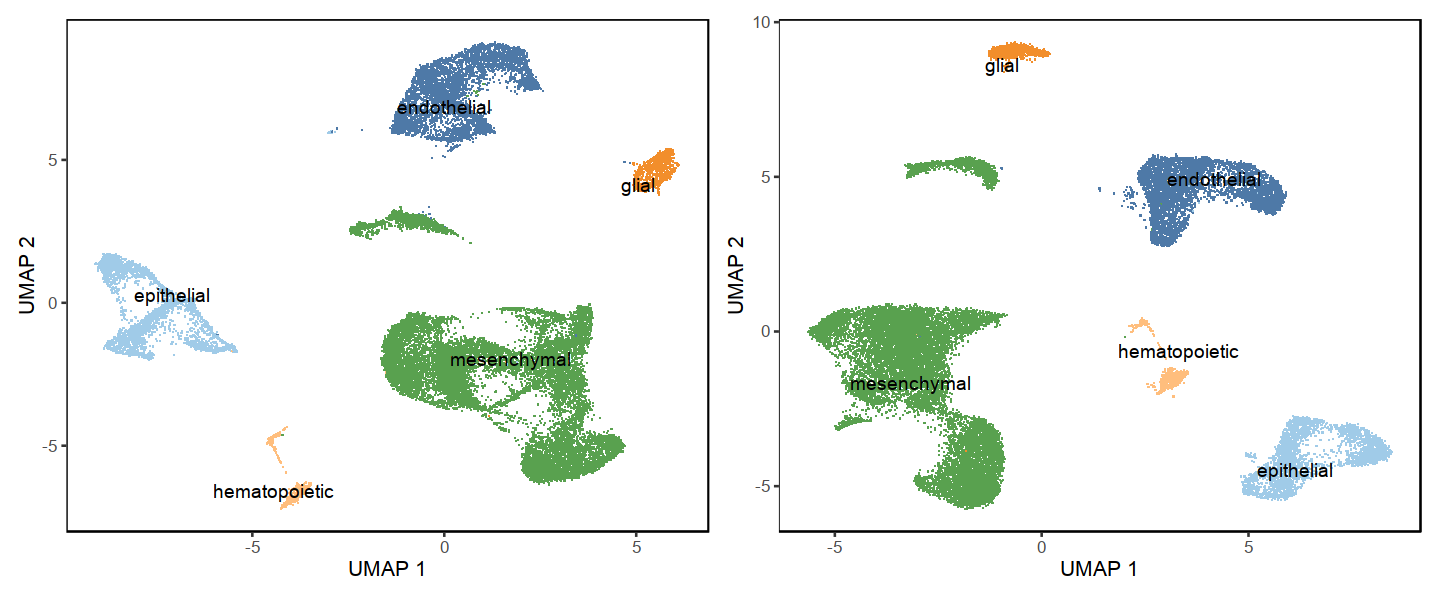

In [25]:
fig.size(5, 12)
do_scatter(obj$umap_before, obj$meta_data, 'Lineage') + 
do_scatter(obj$umap_after, obj$meta_data, 'Lineage')


So most of the mesenchymal cells come from the LOW inflammatory class. 


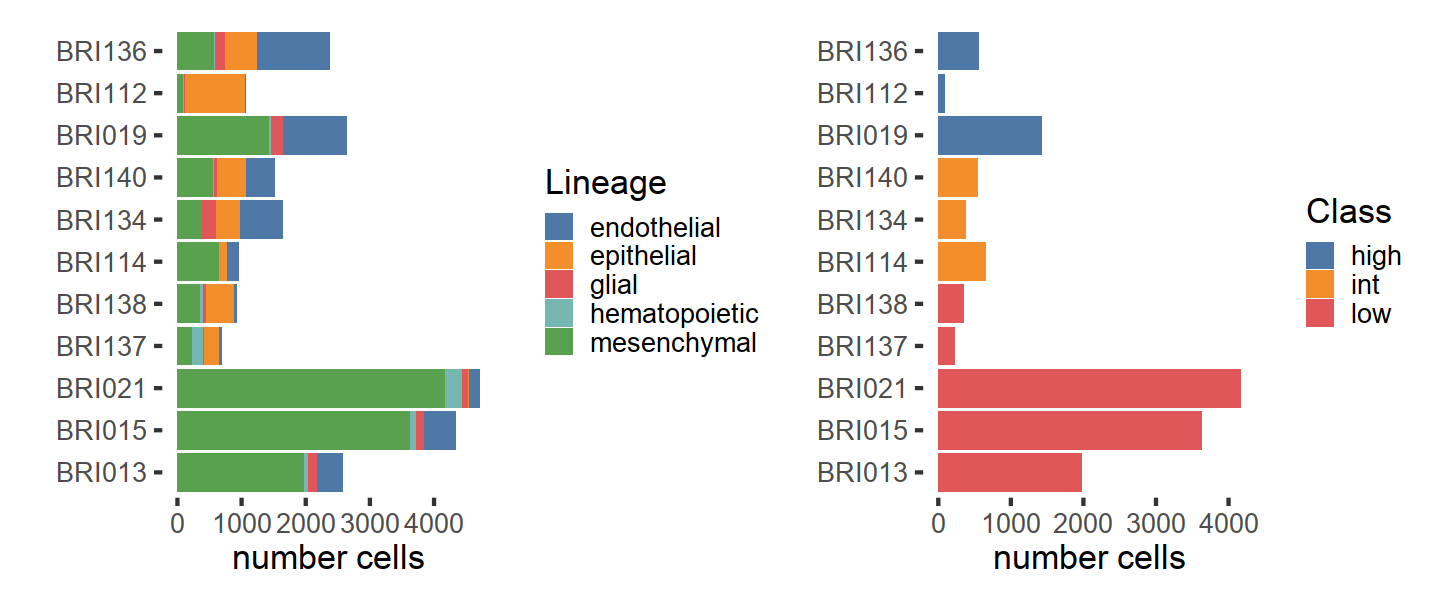

In [26]:
fig.size(5, 12)
plt <- obj$meta_data %>% 
    group_by(Class, Case, LibraryID, DonorID, Lineage) %>% summarize(n = n()) %>% ungroup() %>% 
    mutate(Class = factor(Class)) %>% 
    ggplot(aes(reorder(LibraryID, -as.integer(Class)), n)) + 
        theme_tufte(base_size = 20) + 
        scale_fill_tableau() + 
        labs(y = 'number cells', x = '') +
        coord_flip()

plt + geom_bar(stat = 'identity', aes(fill = Lineage))  +

plt + geom_bar(data = . %>% subset(Lineage == 'mesenchymal'), stat = 'identity', aes(fill = Class)) 



In [27]:
obj$meta_data %>% 
    subset(Lineage %in% c('endothelial', 'mesenchymal')) %>% 
    with(table(LibraryID))

LibraryID
BRI013 BRI015 BRI019 BRI021 BRI112 BRI114 BRI134 BRI136 BRI137 BRI138 BRI140 
  2374   4119   2423   4348     98    819   1039   1698    265    398    996 

## CACHE

In [28]:
saveRDS(obj, '/data/srlab/ik936/Fiona/data/roche_object_040720.rds')


# Mesenchymal clusters 

In [29]:
idx <- which(obj$meta_data$Lineage %in% c('mesenchymal', 'endothelial'))
length(idx)


[1] 18577

In [ ]:
set.seed(1)
# y <- factor(obj$meta_data$Class[idx])
# weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)

fib <- create_object(obj$exprs_raw[, idx], obj$meta_data[idx, ]) %>% 
    do_harmony(
        'LibraryID', theta=.5, 
        max.iter.harmony=10, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf
    ) %>% 
    do_cluster(c(.1, .2, .3, .4))


Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


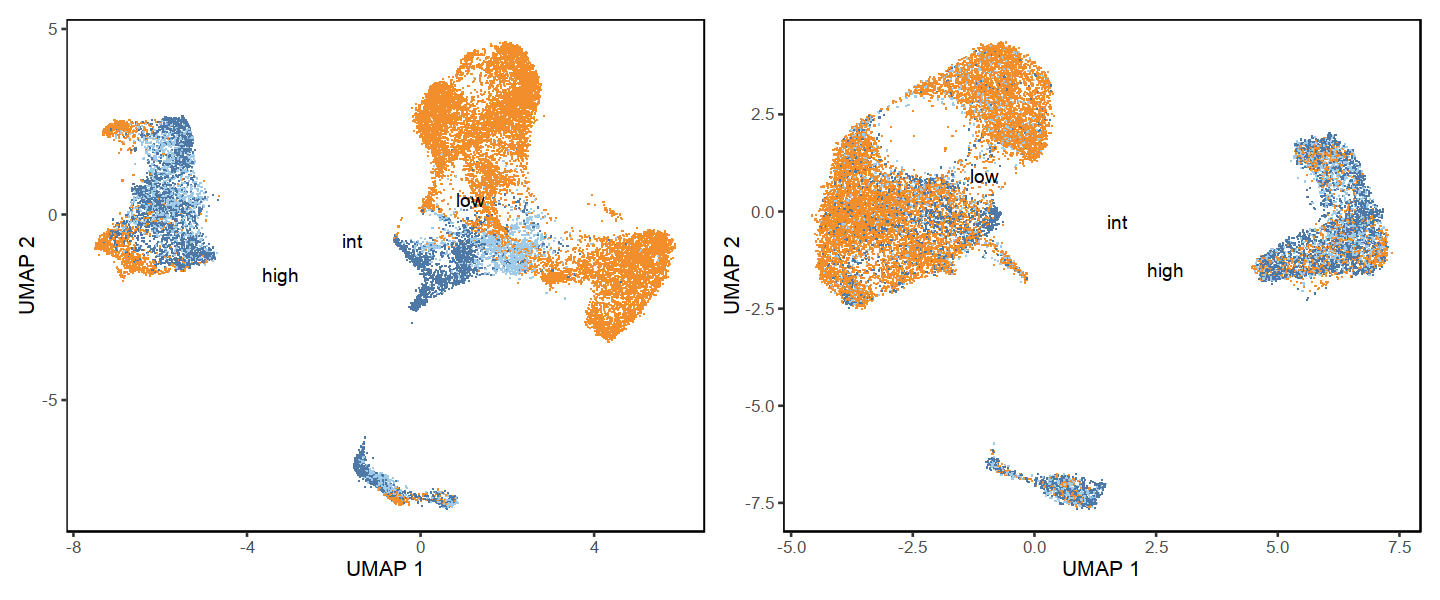

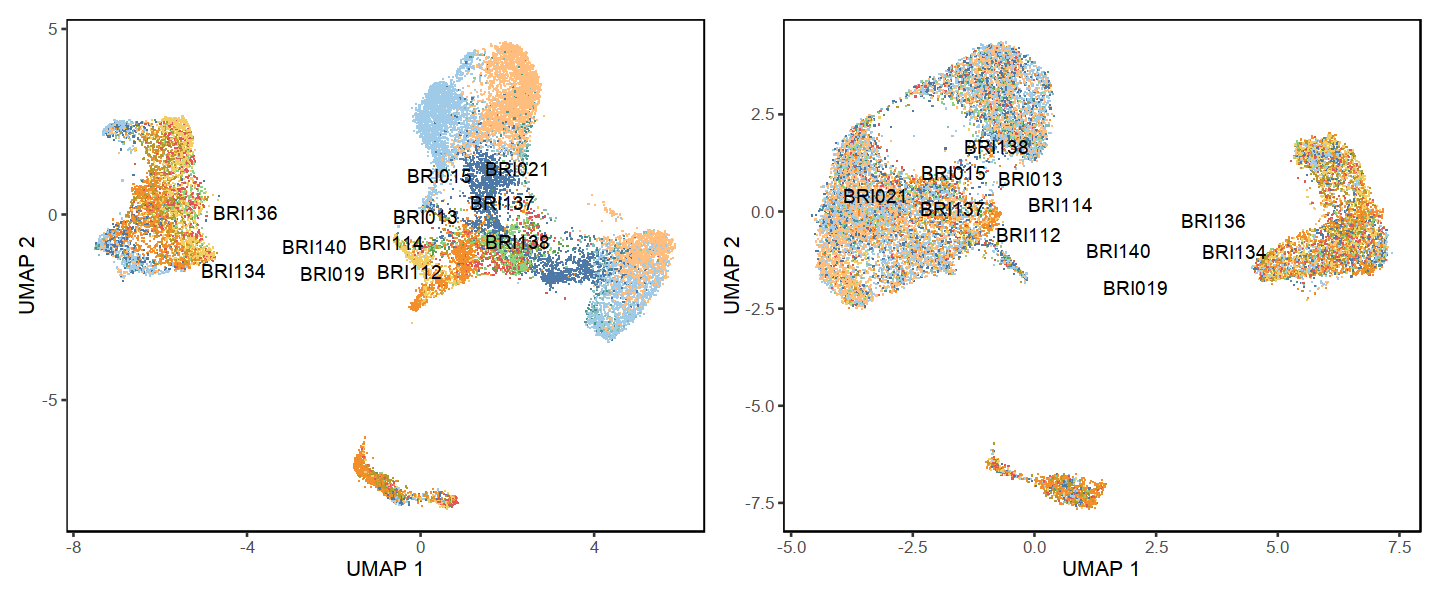

In [31]:
fig.size(5, 12)
do_scatter(fib$umap_before, fib$meta_data, 'Class') + 
do_scatter(fib$umap_after, fib$meta_data, 'Class')

do_scatter(fib$umap_before, fib$meta_data, 'LibraryID') + 
do_scatter(fib$umap_after, fib$meta_data, 'LibraryID')


## Name subtypes

In [52]:
set.seed(1)
fib <- do_cluster(fib, c(.5, .6), append_cols = TRUE)

In [53]:
apply(fib$clusters_df, 2, table)

$res1

   0    1    2    3    4 
8377 4612 4101 1199  288 

$res2

   0    1    2    3    4    5 
7532 4111 3076 1536 1200 1122 

$res3

   0    1    2    3    4    5    6    7 
5207 4105 3073 1539 1226 1200 1132 1095 

$res4

   0    1    2    3    4    5    6    7    8    9 
4101 3765 3073 1539 1428 1232 1137 1103  893  306 

$res5

   0    1   10    2    3    4    5    6    7    8    9 
3743 3068  306 2466 1637 1544 1435 1223 1138 1124  893 

$res6

   0    1   10   11    2    3    4    5    6    7    8    9 
3679 3072  307  303 2446 1662 1539 1443 1243 1148  892  843 


Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


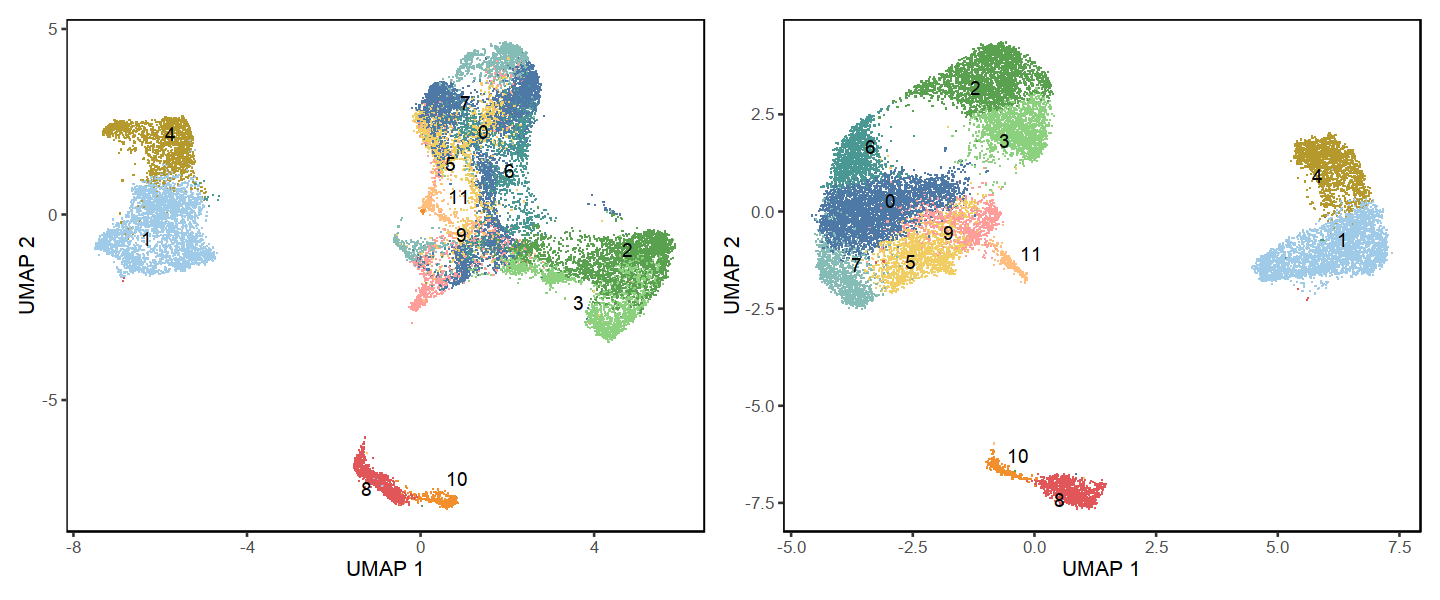

In [124]:
fig.size(5, 12)
do_scatter(fib$umap_before, fib$clusters_df, 'res6') + 
# do_scatter(fib$umap_after, fib$clusters_df, 'res5') + 
do_scatter(fib$umap_after, fib$clusters_df, 'res6')


In [67]:
fib$meta_data$CellType <- case_when(
    fib$clusters_df$res6 %in% c('0', '6', '7', '5') ~ 'ABCA8+ fibroblasts',
    fib$clusters_df$res6 %in% c('2', '3') ~ 'PDGFRA+ fibroblasts',
    fib$clusters_df$res6 %in% c('9') ~ 'Inflammatory fibroblasts',
    fib$clusters_df$res6 %in% c('11') ~ 'Myofibroblasts',
    fib$clusters_df$res6 %in% c('1', '4') ~ 'Endothelial cells',
    fib$clusters_df$res6 %in% c('8', '10') ~ 'Pericytes',
    TRUE ~ 'OTHER'
)


In [58]:
m <- wilcoxauc(fib$exprs_norm, factor(fib$clusters_df$res6))

In [59]:
# top_markers(fib$markers$res4)
top_markers(m)


rank,0,1,10,11,2,3,4,5,6,7,8,9
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ADAMDEC1,PLVAP,MYL9,ACTA2,POSTN,POSTN,ACKR1,APOE,FOSB,PTGDS,RGS5,COL1A2
2,CFD,RAMP2,ACTA2,MYL6,F3,F3,CD74,ADAMDEC1,FOS,FBLN1,NDUFA4L2,COL1A1
3,DCN,SRGN,DSTN,MYL9,CXCL14,PLAT,CLDN5,ABCA8,JUN,CXCL12,NOTCH3,COL3A1
4,APOE,PECAM1,MYH11,MYH11,VSTM2A,CXCL14,VWF,COL3A1,EGR1,DCN,EBF1,LUM
5,CTSC,GNG11,TPM2,NDUFA4,PDGFRA,PDGFRA,FKBP1A,CFD,ZFP36,CCL11,MYL9,COL6A3
6,LUM,IFI27,ADIRF,HHIP,FRZB,FRZB,HLA-DRA,CTSC,JUNB,ADH1B,COL4A1,FTH1
7,FBLN1,RNASE1,ACTB,ACTG2,BMP4,NRG1,RAMP3,ADAM28,CCNL1,MFAP4,PDGFRB,DCN
8,MFAP4,EGFL7,TPM1,FLNA,NBL1,DMKN,TSPAN7,LUM,NFKBIZ,CCDC80,IGFBP7,SPON2
9,ABCA8,FLT1,PLN,TPM1,SOX6,BMP5,SPARCL1,C1S,IER2,LUM,LHFPL6,LGALS1


In [66]:
m %>% 
# fib$markers$res4 %>% 
    subset(feature %in% c('IL11', 'CXCL5', 'CXCL6', 'FAP', 'OSMR')) %>% ## Inflammatory markers
#     subset(feature %in% c('MYL9', 'MYH11', 'ACTA2') & !group %in% c('10', '8')) %>% ## Myofibroblasts
#     subset(feature %in% c('ABCA8', 'PDGFRA')) %>% ## anatomical types
    subset(auc > .6) %>% 
    arrange(feature, -auc)


feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CXCL5,9,0.3828858,0.3773141,9549522,0.6387742,0.000000e+00,0.000000e+00,28.35113,0.6597496
CXCL6,9,0.8463148,0.7370085,10465075,0.7000162,6.792862e-289,4.160889e-286,47.68683,9.1575505
IL11,9,0.2910505,0.2636806,9133134,0.6109217,7.415569e-236,2.880496e-233,24.91103,2.8250818


In [129]:
# fig.size(8, 12)
# do_scatter(fib$umap_after, fib$clusters_df, 'res2', quo(res2), do_labels = FALSE)

In [40]:
# # log1p(t(fib$meta_data[, c('percent_mito'), drop = FALSE])) %>% 
# # wilcoxauc(factor(fib$clusters_df$res4)) %>% 
# #     arrange(-auc)

# fig.size(7, 8)
# cbind(fib$meta_data, fib$clusters_df) %>% 
#     ggplot(aes(percent_mito, reorder(res2, percent_mito))) + 
#         geom_density_ridges2(alpha = .3) + 
#         theme_tufte(base_size = 20) + 
#         geom_vline(xintercept = c(.05, .1), linetype = 2) + 
#         NULL
        

Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


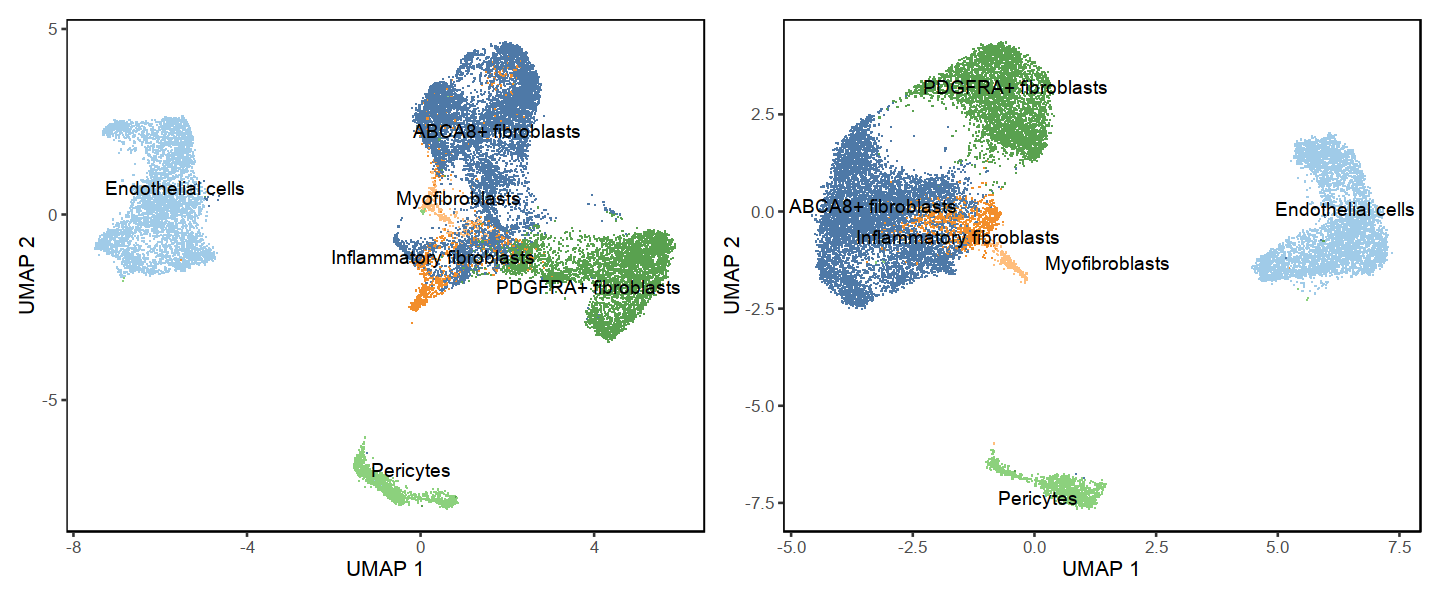

In [68]:
fig.size(5, 12)
do_scatter(fib$umap_before, fib$meta_data, 'CellType') + 
do_scatter(fib$umap_after, fib$meta_data, 'CellType')


In [59]:
# fig.size(5, 12)
# # do_scatter(fib$umap_before, fib$meta_data, 'Class') + 
# do_scatter(fib$umap_after, fib$meta_data, 'Class') + 
# do_scatter(fib$umap_after, fib$meta_data, 'Class', do_points=FALSE, do_density=TRUE) 


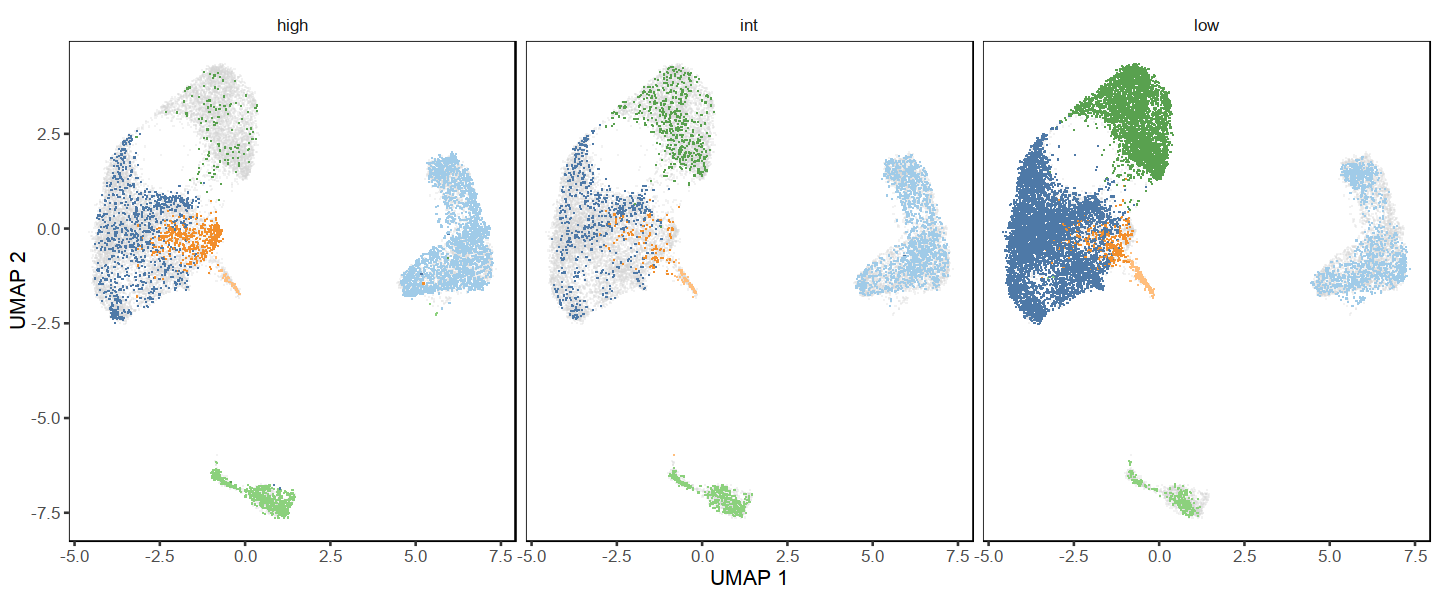

In [70]:
fig.size(5, 12)
do_scatter(
    fib$umap_after, 
    fib$meta_data, 
    label_name = 'CellType', facet_var = quo(Class), 
    do_labels = FALSE
)


In [71]:
fib$meta_data %>% 
    subset(CellType %in% c('ABCA8+ fibroblasts', 'PDGFRA+ fibroblasts', 'Inflammatory fibroblasts')) %>% 
    with(table(Class, CellType)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(CellType == 'Inflammatory fibroblasts')


Class,CellType,N
<chr>,<chr>,<dbl>
high,Inflammatory fibroblasts,0.31894150
int,Inflammatory fibroblasts,0.09262590
low,Inflammatory fibroblasts,0.02843889


## Abundance

### Save Proportions

In [72]:
fib$proportions_fibro <- fib$meta_data %>% 
#     subset(CellType %in% c('ABCA8+ fibroblasts', 'PDGFRA+ fibroblasts', 'Inflammatory fibroblasts', 'Myofibroblasts')) %>% 
    subset(CellType %in% c('ABCA8+ fibroblasts', 'PDGFRA+ fibroblasts', 'Inflammatory fibroblasts')) %>% 
    with(table(CellType, LibraryID)) %>% 
    prop.table(2) %>% 
    data.table() %>% 
    dplyr::inner_join(unique(dplyr::select(fib$meta_data, LibraryID, Class)))


Joining, by = "LibraryID"



In [73]:
fib$proportions_total <- fib$meta_data %>% 
    subset(CellType != 'NA' & !is.na(CellType)) %>% 
#     subset(CellType %in% c('ABCA8+ fibroblasts', 'PDGFRA+ fibroblasts', 'Inflammatory fibroblasts', 'Myofibroblasts')) %>% 
    with(table(CellType, LibraryID)) %>% 
    prop.table(2) %>% 
    data.table() %>% 
    dplyr::inner_join(unique(dplyr::select(fib$meta_data, LibraryID, Class)))


Joining, by = "LibraryID"



### IAF vs Class

In [74]:
fib$proportions_fibro %>% 
    subset(Class == 'high') %>% 
    arrange(CellType, -N)

# & CellType == 'Inflammatory fibroblasts')


CellType,LibraryID,N,Class
<chr>,<chr>,<dbl>,<chr>
ABCA8+ fibroblasts,BRI136,0.61659193,high
ABCA8+ fibroblasts,BRI019,0.59027027,high
ABCA8+ fibroblasts,BRI112,0.50769231,high
Inflammatory fibroblasts,BRI136,0.35201794,high
Inflammatory fibroblasts,BRI019,0.31891892,high
Inflammatory fibroblasts,BRI112,0.09230769,high
PDGFRA+ fibroblasts,BRI112,0.40000000,high
PDGFRA+ fibroblasts,BRI019,0.09081081,high
PDGFRA+ fibroblasts,BRI136,0.03139013,high


`geom_smooth()` using formula 'y ~ x'



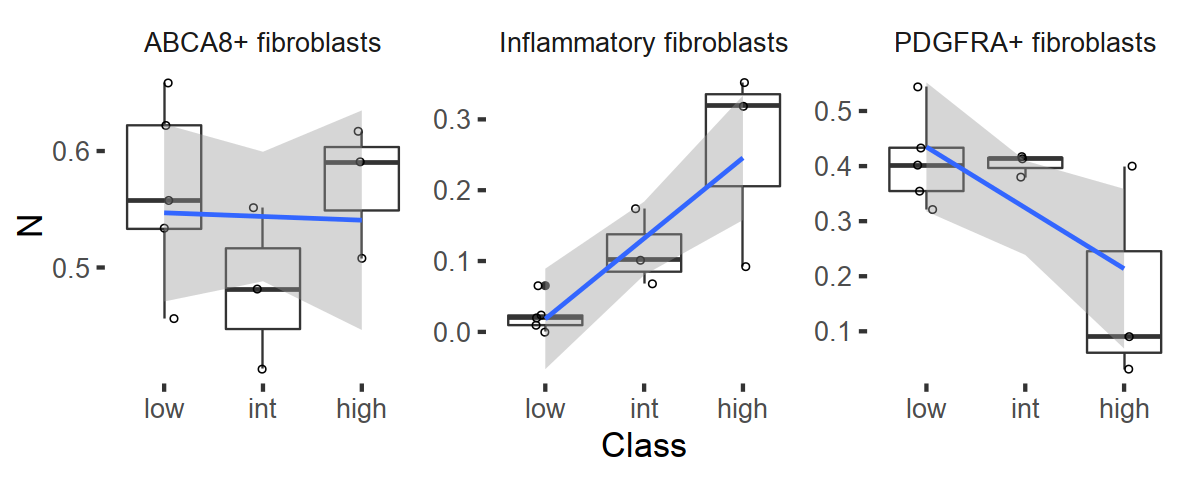

In [75]:
fig.size(4, 10)
fib$proportions_fibro %>%
    dplyr::mutate(Class = factor(Class, c('low', 'int', 'high'))) %>% 
    ggplot(aes(Class, N)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .1)) + 
        theme_tufte(base_size = 20) + 
        facet_wrap(~CellType, scales = 'free') + 
        scale_color_tableau() + 
        geom_smooth(method = 'lm', data = . %>% dplyr::mutate(Class = as.integer(Class))) + 
#         coord_flip() + 
        NULL



## Geneset signatures

In [76]:
fib$scores <- list()

### M4/M5

In [77]:
library(openxlsx)
genes_m4m5 <- openxlsx::read.xlsx('/data/srlab/ik936/Fiona/data/M4_M5_gene list.xlsx', 1, colNames=FALSE) %>% 
    subset(X2 %in% rownames(fib$exprs_norm)) ## NOTE: ~20 genes dropped 

genes_m4m5 <- with(genes_m4m5, split(X2, X3))


In [78]:
fib$scores$m4m5 <- singlecellmethods::do_enrich(fib$exprs_norm, genes_m4m5)

### cytokine

In [79]:
dge_stim <- list()
dge_stim$osm <- openxlsx::read.xlsx('data/deseq2_TNF_OSM for Ilya.xlsx', 'OSM')
dge_stim$il1b <- openxlsx::read.xlsx('data/deseq2_TNF_OSM for Ilya.xlsx', 'IL1B')
dge_stim$tnf <- openxlsx::read.xlsx('data/deseq2_TNF_OSM for Ilya.xlsx', 'TNF')

dge_stim <- lapply(dge_stim, function(x) {
    x %>% 
        subset(log2FoldChange > 1 & padj < .01) %>% 
        subset(gene_name %in% rownames(fib$exprs_norm)) %>% 
        with(gene_name)    
})

lapply(dge_stim, length)

# Do enrichment

$osm
[1] 360

$il1b
[1] 391

$tnf
[1] 400

In [80]:
fib$scores$cytokines <- singlecellmethods::do_enrich(fib$exprs_norm, dge_stim)

### modules

In [81]:
modules <- fread('data/WGCNA_all.csv')[, N := .N, by = moduleColor][N < 2000]

genes_modules <- modules %>% 
    subset(geneName %in% rownames(fib$exprs_norm)) %>% 
    with(split(geneName, moduleColor))


length(genes_modules)
# sort(unlist(map(genes_modules, length)))


[1] 38

In [82]:
fib$scores$modules <- singlecellmethods::do_enrich(fib$exprs_norm, genes_modules)

## DGE

In [83]:
fib$pb <- presto::collapse_counts(fib$exprs_raw, fib$meta_data, c('CellType', 'LibraryID', 'Class'), keep_n=TRUE)
fib$pb$exprs_norm <- normalizeData(fib$pb$counts_mat, 1e4, 'log')


### Cluster markers

In [84]:
library(DESeq2)
gene_min_counts=3 ## present at N counts
gene_min_obs=5 ## present in N samples
dge_formula=~1+CellType
# library(BiocParallel)
# register(MulticoreParam(4))


In [85]:
# idx_use <- which(fib$pb$meta_data$tissue == tissue_use)
counts_mat <- fib$pb$counts_mat#[, idx_use]
meta_data <- fib$pb$meta_data#[idx_use, ]
genes_use <- rownames(counts_mat)[which(rowSums(counts_mat >= gene_min_counts) >= gene_min_obs)]

In [86]:
length(genes_use)

[1] 14896

In [87]:
dim(counts_mat)
head(meta_data)


[1] 19952    65

,CellType,LibraryID,Class,N
,<chr>,<chr>,<chr>,<int>
1,PDGFRA+ fibroblasts,BRI013,low,726
2,Endothelial cells,BRI013,low,401
3,Myofibroblasts,BRI013,low,73
4,ABCA8+ fibroblasts,BRI013,low,964
5,Inflammatory fibroblasts,BRI013,low,118
6,Pericytes,BRI013,low,92


In [88]:
# fib$pb$meta_data %>% subset(is.na(CellType))

In [89]:
dds <- DESeqDataSetFromMatrix(
    countData = counts_mat[genes_use, ],
    colData = meta_data,
    design = dge_formula) %>% 
DESeq(
    parallel=FALSE, 
    betaPrior=TRUE, ## gives each cluster its own beta term
    sfType='poscounts' ## necessary when some genes have 0 count
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommen

In [90]:
resultsNames(dds)

[1] "Intercept"                        "CellTypeABCA8..fibroblasts"      
[3] "CellTypeEndothelial.cells"        "CellTypeInflammatory.fibroblasts"
[5] "CellTypeMyofibroblasts"           "CellTypePDGFRA..fibroblasts"     
[7] "CellTypePericytes"

In [91]:
contrast_var <- 'CellType'
ddres <- lapply(grep(contrast_var, resultsNames(dds), value = TRUE), function(resname) {
    results(dds, name = resname) %>% 
        data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(group = resname)
}) %>% 
    dplyr::bind_rows() %>% 
    dplyr::mutate(group = gsub(contrast_var, '', group)) %>% 
    dplyr::select(feature, group, everything())


In [92]:
top_markers_dds(ddres, lfc_min=1, n=20)


rank,ABCA8..fibroblasts,Endothelial.cells,Inflammatory.fibroblasts,Myofibroblasts,PDGFRA..fibroblasts,Pericytes
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GPC6,CD34,MXRA5,MYH11,HSD17B2,TINAGL1
2,CHL1,FLT1,VCAN,HHIP,PDGFRA,LGI4
3,FBLN5,RAMP2,COL16A1,HSD17B6,KREMEN1,ARHGDIB
4,SVEP1,TM4SF18,MRC2,NPNT,PDGFD,EBF1
5,TCF21,ESAM,TWIST2,CES1,EDNRB,MEF2C
6,PTGER2,LMO2,GPC6,MFAP5,PTGER2,ADAP2
7,CCDC80,MMRN2,DNM1,PLN,RGS17,ITGA7
8,MRC2,GIMAP4,ANTXR1,SOSTDC1,DMKN,ESAM
9,SPON1,MALL,MMP2,SPON1,SEMA4D,MAP3K7CL


Note that the inflammatory genes are specific to IAFs but not the strongest markers. Maybe because they are really upregulated more in inflammatory samples only? 


In [ ]:
ddres %>% 
    subset(feature %in% c('IL11', 'CXCL5', 'CXCL6')) %>% 
    subset(log2FoldChange >= .5 & padj < .01)


,feature,group,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3133,CXCL6,ABCA8..fibroblasts,68.53144,2.353874,0.5423391,4.340224,1.423373e-05,3.174431e-04
5911,IL11,ABCA8..fibroblasts,14.81355,1.821214,0.5084450,3.581928,3.410675e-04,4.399464e-03
32924,CXCL5,Inflammatory.fibroblasts,10.03312,3.022535,0.6170768,4.898150,9.674305e-07,6.957933e-05
32925,CXCL6,Inflammatory.fibroblasts,68.53144,2.829248,0.5523958,5.121776,3.026715e-07,2.597729e-05
35703,IL11,Inflammatory.fibroblasts,14.81355,2.762967,0.5207357,5.305892,1.121233e-07,1.053631e-05


In [94]:
fib$pb$markers <- ddres

### Cluster markers (within M4/M5)

In [5]:
library(DESeq2)
gene_min_counts=3 ## present at N counts
gene_min_obs=5 ## present in N samples
dge_formula=~1+CellType
# library(BiocParallel)
# register(MulticoreParam(4))


In [9]:
idx_use <- which(fib$pb$meta_data$Class == 'high')
counts_mat <- fib$pb$counts_mat[, idx_use]
meta_data <- fib$pb$meta_data[idx_use, ]
genes_use <- rownames(counts_mat)[which(rowSums(counts_mat >= gene_min_counts) >= gene_min_obs)]


In [10]:
length(genes_use)

[1] 13191

In [11]:
dim(counts_mat)
head(meta_data)


[1] 19952    18

,CellType,LibraryID,Class,N
,<chr>,<chr>,<chr>,<int>
13,Pericytes,BRI019,high,478
14,Endothelial cells,BRI019,high,997
15,ABCA8+ fibroblasts,BRI019,high,546
16,PDGFRA+ fibroblasts,BRI019,high,84
17,Inflammatory fibroblasts,BRI019,high,295
18,Myofibroblasts,BRI019,high,23


In [88]:
# fib$pb$meta_data %>% subset(is.na(CellType))

In [13]:
dds <- DESeqDataSetFromMatrix(
    countData = counts_mat[genes_use, ],
    colData = meta_data,
    design = dge_formula) %>% 
DESeq(
    parallel=FALSE, 
    betaPrior=TRUE, ## gives each cluster its own beta term
    sfType='poscounts' ## necessary when some genes have 0 count
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommen

In [14]:
resultsNames(dds)

[1] "Intercept"                        "CellTypeABCA8..fibroblasts"      
[3] "CellTypeEndothelial.cells"        "CellTypeInflammatory.fibroblasts"
[5] "CellTypeMyofibroblasts"           "CellTypePDGFRA..fibroblasts"     
[7] "CellTypePericytes"

In [15]:
contrast_var <- 'CellType'
ddres <- lapply(grep(contrast_var, resultsNames(dds), value = TRUE), function(resname) {
    results(dds, name = resname) %>% 
        data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(group = resname)
}) %>% 
    dplyr::bind_rows() %>% 
    dplyr::mutate(group = gsub(contrast_var, '', group)) %>% 
    dplyr::select(feature, group, everything())


In [25]:
# top_markers_dds(ddres, lfc_min=1, n=20)


Note that the inflammatory genes are specific to IAFs but not the strongest markers. Maybe because they are really upregulated more in inflammatory samples only? 


In [26]:
ddres %>% 
    subset(feature %in% c('IL11', 'CXCL5', 'CXCL6')) %>% 
    subset(log2FoldChange >= .5 & padj < .01)


,feature,group,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29095,CXCL5,Inflammatory.fibroblasts,28.38371,3.048591,0.6789288,4.490296,7.112422e-06,0.0008897222


In [27]:
fib$pb$markers_m4m5high <- ddres

In [28]:
saveRDS(fib, '/data/srlab/ik936/Fiona/data/fib_object_040720.rds')

### Inflam status

In [15]:
fib <- readRDS('/data/srlab/ik936/Fiona/data/fib_object_040720.rds')

In [22]:
library(DESeq2)
gene_min_counts=3 ## present at N counts
gene_min_obs=5 ## present in N samples
# dge_formula=~1 + ClassCellType
dge_formula=~1 + ClassCellType
# library(BiocParallel)
# register(MulticoreParam(4))


In [23]:
# idx_use <- which(fib$pb$meta_data$tissue == tissue_use)
counts_mat <- fib$pb$counts_mat#[, idx_use]
meta_data <- fib$pb$meta_data %>% 
    dplyr::mutate(ClassCellType = paste(Class, CellType, sep = '_'))
genes_use <- rownames(counts_mat)[which(rowSums(counts_mat >= gene_min_counts) >= gene_min_obs)]


In [24]:
dds <- DESeqDataSetFromMatrix(
    countData = counts_mat[genes_use, ],
    colData = meta_data,
    design = dge_formula
) %>% 
DESeq(
    parallel=FALSE, 
    betaPrior=TRUE, ## gives each cluster its own beta term
    sfType='poscounts' ## necessary when some genes have 0 count
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommen

In [25]:
contrast_var <- 'ClassCellType'
ddres <- lapply(grep(contrast_var, resultsNames(dds), value = TRUE), function(resname) {
    results(dds, name = resname) %>% 
        data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(group = resname)
}) %>% 
    dplyr::bind_rows() %>% 
    dplyr::mutate(group = gsub(contrast_var, '', group)) %>% 
    dplyr::select(feature, group, everything())


In [102]:
# top_markers_dds(ddres, lfc_min=1, n=20)
fib$pb$degs2 <- ddres

In [26]:
pryr::object_size(dds)

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp



42.8 MB

In [27]:
## also save raw DESeq2 object
fib$pb$dds <- dds


Can we contrast to low group within each cluster? 


In [81]:
cluster_names <- gsub('ClassCellType', '', grep('^ClassCellType', resultsNames(dds), value = TRUE)) %>%
    strsplit('_') %>% map_chr(2) %>% unique()

In [82]:
res <- list(
    high = map_dfr(cluster_names, function(cluster_name) {
        DESeq2::results(dds, c('ClassCellType', paste0('high_', cluster_name), paste0('low_', cluster_name))) %>% 
        data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(Cluster = cluster_name)        
    }, .id = 'Cluster'),
    int = map_dfr(cluster_names, function(cluster_name) {
        DESeq2::results(dds, c('ClassCellType', paste0('int_', cluster_name), paste0('low_', cluster_name))) %>% 
        data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(Cluster = cluster_name)
    }, .id = 'Cluster')
) %>% 
    bind_rows(.id = 'Contrast') %>% 
    dplyr::select(Cluster, Feature=feature, Contrast, everything())


In [93]:
table(res$Cluster)


      ABCA8..fibroblasts        Endothelial.cells Inflammatory.fibroblasts 
                   29792                    29792                    29792 
          Myofibroblasts      PDGFRA..fibroblasts                Pericytes 
                   29792                    29792                    29792 

In [99]:
fib$pb$degs2_low_contrast <- res
saveRDS(fib, '/data/srlab/ik936/Fiona/data/roche_object_040720.rds')


In [96]:
fwrite(res, '/data/srlab/ik936/Fiona/figures/table_status_dge_contrast_to_low.csv', sep=',')

## Batch effect assessment

In [103]:
library(lisi)


Attaching package: ‘lisi’


The following object is masked _by_ ‘.GlobalEnv’:

    meta_data




In [104]:
fib$lisi <- list()
fib$lisi$pca <- lisi::compute_lisi(fib$V, fib$meta_data, c('Class', 'LibraryID'))
fib$lisi$harmony <- lisi::compute_lisi(t(fib$Z_cos), fib$meta_data, c('Class', 'LibraryID'))


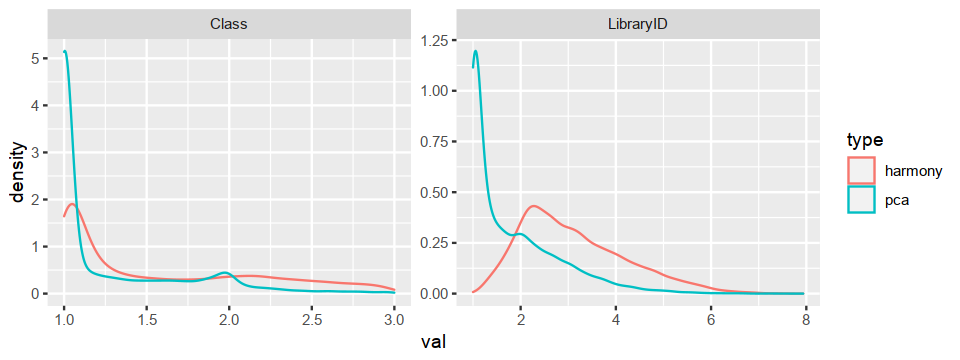

In [110]:
fig.size(3, 8)
bind_rows(fib$lisi, .id = 'type') %>% 
    tidyr::gather(key, val, Class, LibraryID) %>% 
    ggplot(aes(val, color = type)) + 
        geom_density() + 
#         geom_density_ridges2() + 
        facet_wrap(~key, scales = 'free', nrow = 1)

In [125]:
rbind(
    tibble(
        type = 'pca',
        mu = mean(fib$lisi$pca$LibraryID),
        sig = sd(fib$lisi$pca$LibraryID)
    ),
    tibble(
        type = 'harmony',
        mu = mean(fib$lisi$harmony$LibraryID),
        sig = sd(fib$lisi$harmony$LibraryID)
    )
)



type,mu,sig
<chr>,<dbl>,<dbl>
pca,1.836716,0.9530088
harmony,3.110593,1.1086166


In [ ]:
fib$me

## CACHE

In [112]:
saveRDS(fib, '/data/srlab/ik936/Fiona/data/fib_object_040720.rds')

In [5]:
fib <- readRDS('/data/srlab/ik936/Fiona/data/fib_object_033020.rds')

In [65]:
# m <- wilcoxauc(obj$exprs_norm, obj$meta_data$sample)


In [66]:
# m %>% 
#     subset(feature %in% c('PRG4', 'PTPRC', 'EPCAM1')) %>% 
#     subset(auc > .5) %>% 
#     identity()

## DGE within M4/M5

In [1]:
fib <- readRDS('/data/srlab/ik936/Fiona/data/roche_object_040720.rds')

In [ ]:
fib$

In [ ]:
idx <- which fib$meta_data$... == ''

# Trajectory 

In [3]:
obj <- readRDS('/data/srlab/ik936/Fiona/data/fib_object_040720.rds')

Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


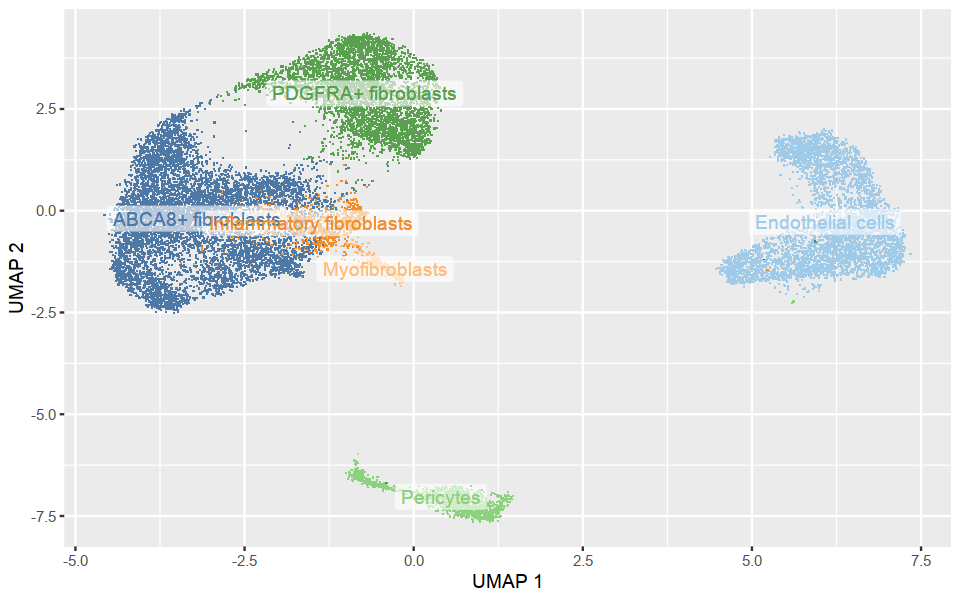

In [11]:
fig.size(5, 8)
do_scatter(obj$umap_after, obj$meta_data, 'CellType')


In [14]:
idx <- which(obj$meta_data$CellType %in% c('ABCA8+ fibroblasts', 'PDGFRA+ fibroblasts', 'Inflammatory fibroblasts')) %>% 
    intersect(which(obj$umap_after[, 2] > -5 & obj$umap_after[, 1] < 2.5))


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


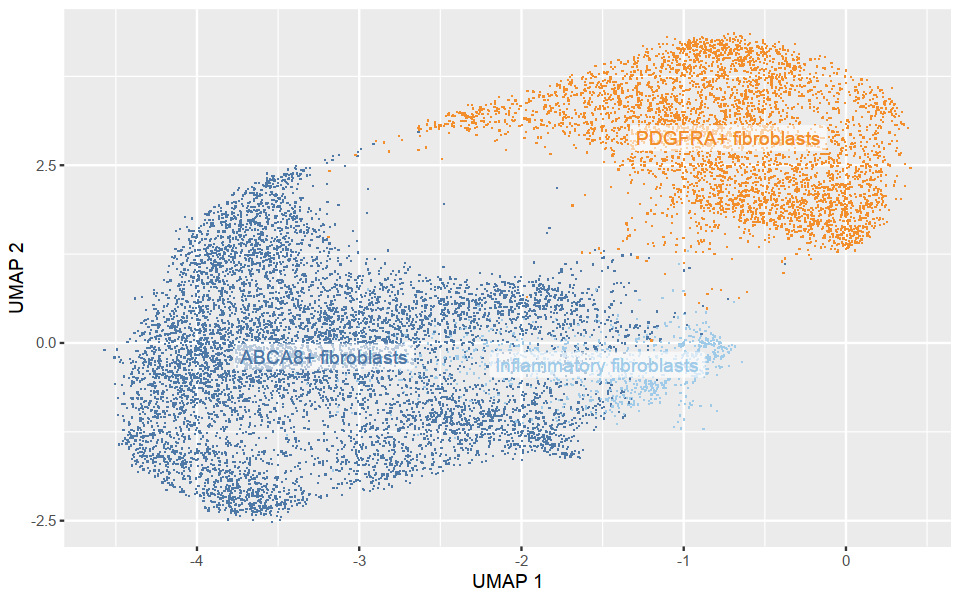

In [15]:
fig.size(5, 8)
do_scatter(obj$umap_after[idx, ], obj$meta_data[idx, ], 'CellType')


## Princurve

In [17]:
dim(obj$Z_cos)

[1]    20 18577

Without approx_points, takes ~1.5 minutes. 


In [92]:
library(princurve)
system.time({
#     pres <- princurve::principal_curve(t(obj$Z_corr[, idx]), approx_points = 1e3)$lambda
#     pres <- princurve::principal_curve(t(obj$Z_cos[, idx]))$lambda
#     pres <- princurve::principal_curve(t(obj$Z_cos[, idx]), approx_points = 1e3)$lambda
#     pres <- princurve::principal_curve(obj$umap_after[idx, ], approx_points = 1e3)$lambda
    pres <- princurve::principal_curve(obj$umap_after[idx, ])$lambda    
    pres <- rescale(pres) * 100
})


obj$meta_data$pseudotime <- NA
obj$meta_data$pseudotime[idx] <- pres


   user  system elapsed 
 19.848   0.003  19.955 

## UMAP

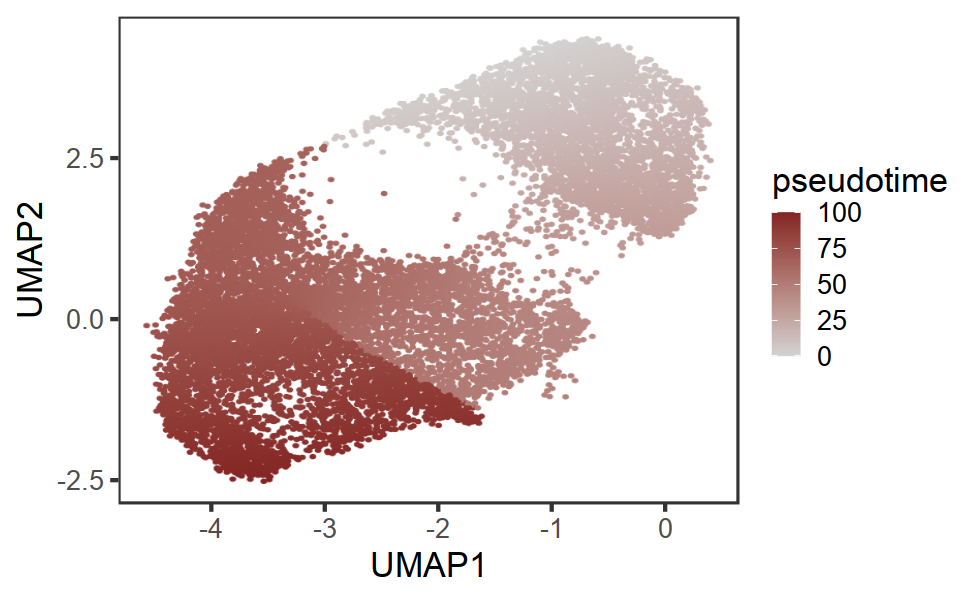

In [93]:
# plotFeatures
fig.size(5, 8)
obj$umap_after %>% 
    cbind(obj$meta_data) %>%
    subset(!is.na(pseudotime)) %>% 
    ggplot(aes(`1`, `2`, color=pseudotime)) + 
        geom_point_rast(shape = 16, size = .3, 
                        dpi = 300, height=2, width=2)  + 
        theme_test(base_size = 20) + 
#         scale_color_gradient2(midpoint = 50, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
#         scale_fill_gradient2(midpoint = 50, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
#         scale_color_gradient2_tableau() + 
#         scale_color_gradient_tableau() + 
        scale_color_gradient(low = 'lightgrey', high = muted('red')) + 
        labs(x = 'UMAP1', y = 'UMAP2') + 
        NULL



## Density

In [90]:
# fig.size(4, 8)
# obj$meta_data %>% 
#     subset(!is.na(pseudotime)) %>% 
#     ggplot(aes(100 - pseudotime, CellType)) + 
#         geom_density_ridges2() + 
#         theme_test(base_size = 16) + 
#         labs(x = 'Trajectory Position', y = 'Normalized Density') + 
#         NULL
        


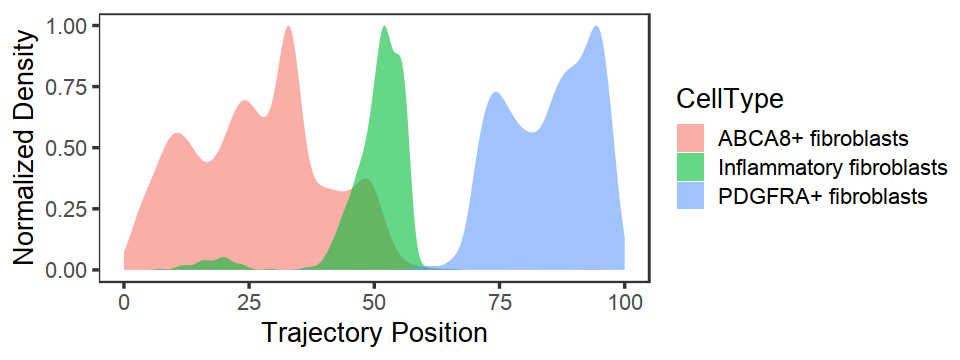

In [94]:
fig.size(3, 8)
obj$meta_data %>% 
    subset(!is.na(pseudotime)) %>% 
    ggplot(aes(100 - pseudotime, fill = CellType)) + 
#         geom_density_ridges2() + 
        geom_density(aes(y = ..ndensity..), color = NA, alpha = .6) + 
        theme_test(base_size = 16) + 
        labs(x = 'Trajectory Position', y = 'Normalized Density') + 
        NULL
        


## Pseudotime expression

In [95]:
bin_95 <- function(data_df, xvar, yvars, num.bin) {
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    
    .breaks <- unique(quantile(x, probs=seq(0, 1, length.out=num.bin)))
    bin_means <- .5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest=TRUE)
    levels(bins_freq) <- bin_means 
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% as.numeric
    
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]        
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% as.numeric
        data.frame(xval = xmeans) %>% 
            cbind(
                Reduce(rbind, lapply(split(y, as.integer(bins_freq)), function(.x) quantile(.x, c(.05, .95)))) %>% 
                    data.frame() %>% 
                    dplyr::mutate(symbol = yvar)
            ) %>% 
            cbind(yval = ymeans, ysd = ysd)
             
    })) %>% data.frame()
    return(res_df)
}

In [97]:
idx <- which(!is.na(obj$meta_data$pseudotime))
data_df <- obj$meta_data[idx, ] %>% 
#     cbind(t(scaleData(obj$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx]))) %>% 
#     cbind(apply(t(scaleData(roche$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx])), 2, rescale)) %>%
    cbind(t(scaleData(obj$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx]))) %>%
    bin_95('pseudotime', c('ABCA8', 'PDPN', 'PDGFRA'), 100)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



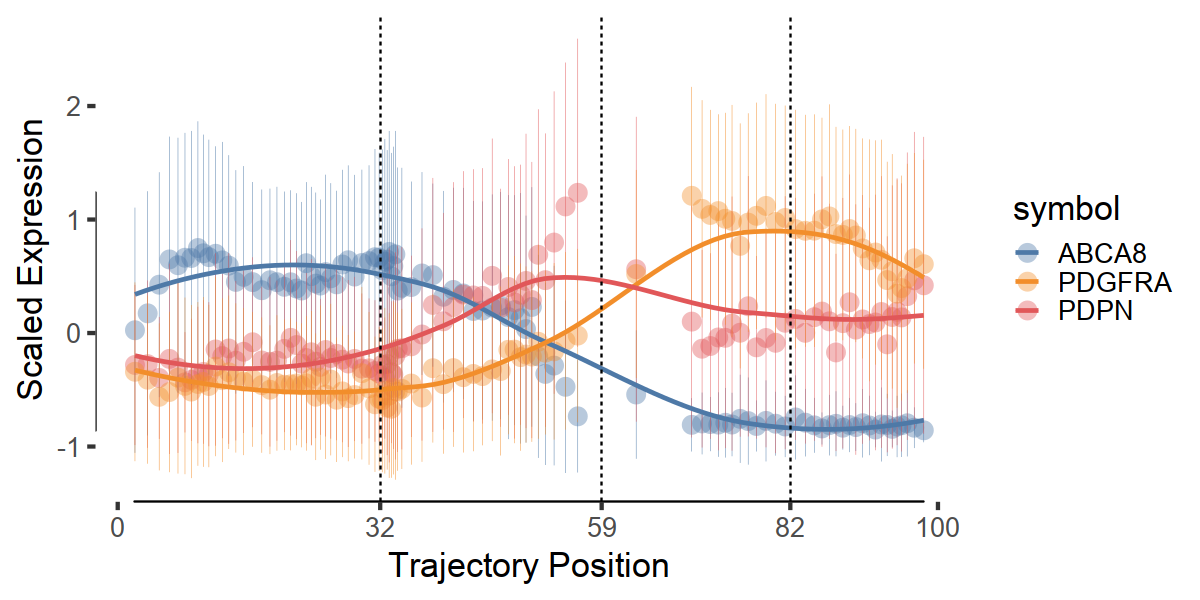

In [98]:
fig.size(5, 10)
data_df %>% 
    ggplot(aes(100 - xval, yval, color = symbol)) + 
        geom_point(shape = 16, size = 5, alpha = .4) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
#         facet_wrap(~key, scales = 'free') + 
        geom_smooth(se = FALSE) + 
        scale_color_tableau() + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        labs(x = 'Trajectory Position', y = 'Scaled Expression') + 
        geom_vline(xintercept = c(32, 59, 82), linetype = 2) + 
        scale_x_continuous(breaks = c(0, 32, 59, 82, 100)) + 
        NULL


## Cache

In [99]:
saveRDS(obj, '/data/srlab/ik936/Fiona/data/fib_object_040720.rds')
